# **NLP Sentiment Analysis on Amazon Cell Phone Reviews**

#### Amazon Cell Phone Reviews contain 82,815 customer reviews from 2004 to Sep 2019. Data size is about 28 M. Most popular brands are Samsung and Apple, with the percentage of 50% and 13% respectively.  About 96% cell Phones sold by carries are renewed or refurbished models. Among all brands Xiaomi has the highest rating. Each review is for an item with brand name and a rating ranged from 1 to 5. So the dataset is a perfect candidate for NLP sentiment analysis. In this project I will implement CNN/LSTM/GRU neural neworks for the sentiment analysis on the reviews.

## **Part I. Data Preprocessing, WordCloud and Vader Analysis**

### **Load Data**

### Data downloaded from Kaggle and saved in My Drive; Load data from Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data Sets/'
items = pd.read_csv(path+"20190928-items.csv")
reviews = pd.read_csv(path+"20190928-reviews.csv")

### **Overview the Data**

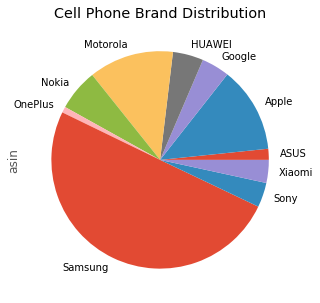

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
ax = items.groupby("brand").count()["asin"].plot(kind="pie", 
                                                 figsize=(8, 5),
                                                 title="Cell Phone Brand Distribution")
plt.show()

In [4]:
# Data overview
print("The data contains {0[0]: ,.0f} rows and {0[1]: .0f} variables.".format(reviews.shape))
reviews.head()

The data contains  82,815 rows and  8 variables.


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,11-Oct-05,False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,7-Jan-04,False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,30-Dec-03,False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,18-Mar-04,False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,28-Aug-05,False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [0]:
# Merge review data to item data by "asin"
reviews = pd.merge(reviews, items, how="left", left_on="asin", right_on="asin")

In [6]:
# Rename columns
reviews.rename(columns={"rating_x": "rating", "title_x": "title", "title_y": "item_title", "rating_y": "overall_rating"}, inplace=True)
reviews.head()

,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,prices
0,B0000SX2UC,Janet,3,11-Oct-05,False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
1,B0000SX2UC,Luke Wyatt,1,7-Jan-04,False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
2,B0000SX2UC,Brooke,5,30-Dec-03,False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
3,B0000SX2UC,amy m. teague,3,18-Mar-04,False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN
4,B0000SX2UC,tristazbimmer,4,28-Aug-05,False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,Nokia,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,NaN


In [7]:
reviews=reviews[['asin','rating','date','title','body','brand']]
reviews.head()

,asin,rating,date,title,body,brand
0,B0000SX2UC,3,11-Oct-05,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,Nokia
1,B0000SX2UC,1,7-Jan-04,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,Nokia
2,B0000SX2UC,5,30-Dec-03,Love This Phone,"This is a great, reliable phone. I also purcha...",Nokia
3,B0000SX2UC,3,18-Mar-04,"Love the Phone, BUT...!","I love the phone and all, because I really did...",Nokia
4,B0000SX2UC,4,28-Aug-05,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,Nokia


## **Preprocessing Data**

In [0]:
# Add class label
reviews["class"] = reviews["rating"].apply(lambda x: 2 if x>3 else(1 if x==3 else 0))

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Preprocess review text
# Define preprocess function
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [word for word in wordList if word not in keywords]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I love Apple Smart Phones.")

'love smart phone'

In [0]:
# Clean dataset
reviews["body"] = reviews["body"].astype("str")
reviews["clean_text"] = reviews["body"].apply(clean_text)

In [12]:
reviews["clean_text"].head().values

array(["a600 awhile absolute doo doo read review detect rage stupid thing finally died used bought garage sale 1 wonder sold cheap bad  hate menu take forever get want scroll endlessly usually phone numbered category u simply press  get want go  pain put silent vibrate class ring turn immediately there's fast way silence damn thing always remember put silent learned hard way  true case mission get break ur nail process also damage case time u try reason started giving problem succeed opening  button could bit bigger vibration could stronger good  reception shabby using elevator remarkable feat considering old would lose service simply putting pocket  compared old work quite well ring tone loud enough hear actually charge quickly great battery life heat like potatoe oven either long convos  nice bright large screen  cute way customize scroll bar set purple pink aqua orange etc overall okay serf purpose definitely pale comparison new phone coming sprint get get great",
       "due softwa

## **Create Wordcloud**

In [13]:
# Define word frequency function
def word_freq_dict(text):
    wordList = text.split()
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict
word_freq_dict("I love movies. I watched starwar, I enjoyed it and watched it again.")

{'I': 3,
 'again.': 1,
 'and': 1,
 'enjoyed': 1,
 'it': 2,
 'love': 1,
 'movies.': 1,
 'starwar,': 1,
 'watched': 2}

In [0]:
# Import wordcloud
from wordcloud import WordCloud, ImageColorGenerator

# Create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
# Function to plot top10 positive words and top10 negative words in a grouped bar plot 
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

### **WordCloud for Total Reviews**

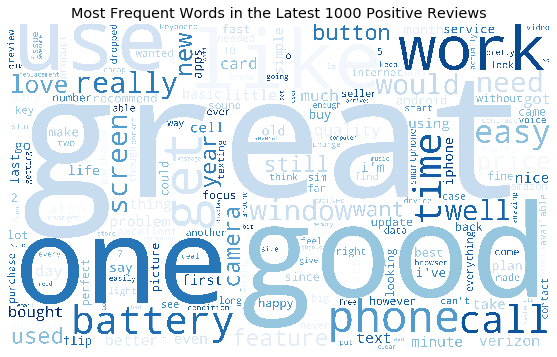

In [15]:
# Plot wordclouds for latest 1000 reviews for total reviews
review_pos = " ".join(reviews[reviews["class"]==2]["clean_text"][0:1000])
review_pos_word_freq = word_freq_dict(review_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(review_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews")

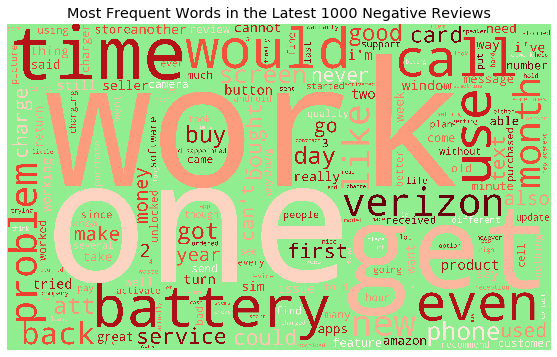

In [16]:
review_neg = " ".join(reviews[reviews["class"]==0]["clean_text"][0:1000])
review_neg_word_freq = word_freq_dict(review_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Reds",
                      background_color="lightgreen")
wordcloud_from_frequency(review_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews")

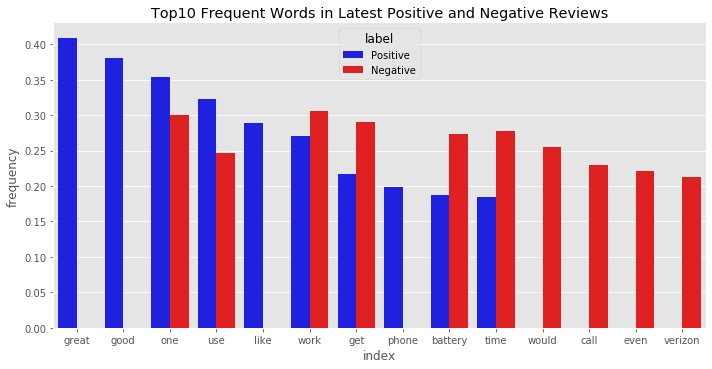

In [17]:
topn_wordfreq_bar_both(review_pos_word_freq, review_neg_word_freq, 
                       min(sum(reviews["class"]==2), 1000), 
                       min(sum(reviews["class"]==0), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews", 
                       ["blue", "red"], 
                       height=5, aspect=2)

### **WordCloud for Apple Reviews**

In [0]:
# Create brand subsets
apple = reviews[reviews["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
samsung = reviews[reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)
xiaomi = reviews[reviews["brand"]=="Xiaomi"].sort_values(by=["date"], ascending=False)

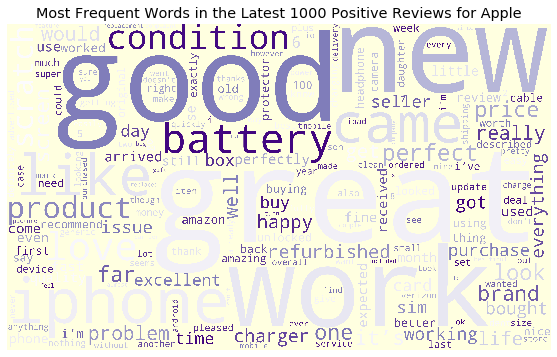

In [19]:
# Plot wordclouds for latest 1000 reviews for Apple
apple_pos = " ".join(apple[apple["class"]==2]["clean_text"][0:1000])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Purples",
                      background_color="lightyellow")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Apple")

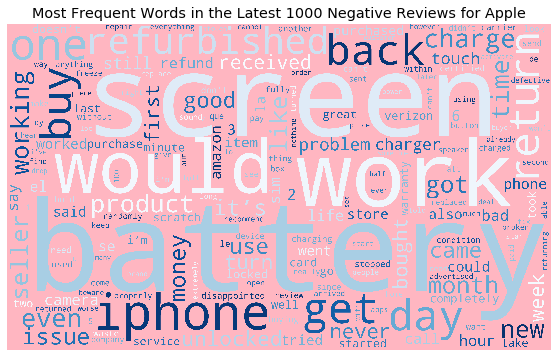

In [21]:
apple_neg = " ".join(apple[apple["class"]==0]["clean_text"][0:1000])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="lightpink")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Apple")

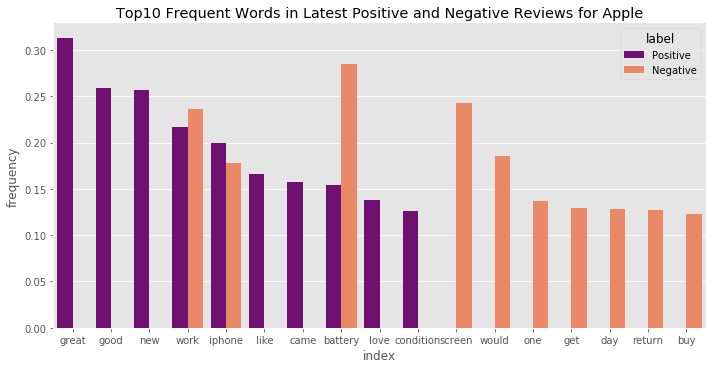

In [22]:
topn_wordfreq_bar_both(apple_pos_word_freq, apple_neg_word_freq, 
                       min(sum(apple["class"]==2), 1000), 
                       min(sum(apple["class"]==0), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Apple", 
                       ["purple", "coral"], 
                       height=5, aspect=2)

### **WordCloud for Samsung Reviews**

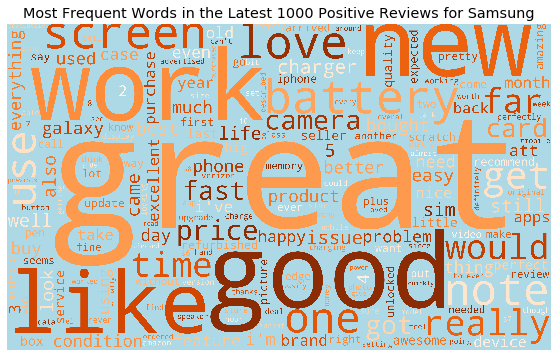

In [23]:
samsung_pos = " ".join(samsung[samsung["class"]==2]["clean_text"][0:1000])
samsung_pos_word_freq = word_freq_dict(samsung_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Oranges",
                      background_color="lightblue")
wordcloud_from_frequency(samsung_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

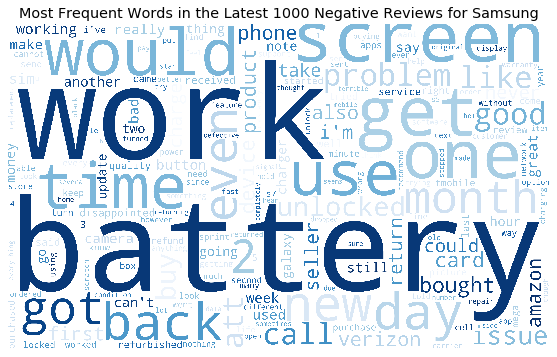

In [25]:
samsung_neg = " ".join(samsung[samsung["class"]==0]["clean_text"][0:1000])
samsung_neg_word_freq = word_freq_dict(samsung_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(samsung_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")

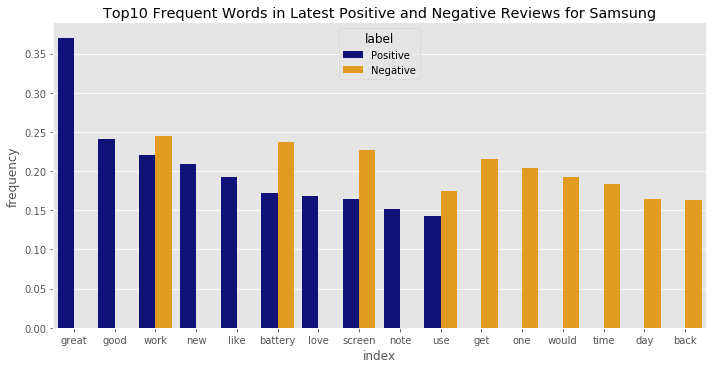

In [26]:
topn_wordfreq_bar_both(samsung_pos_word_freq, samsung_neg_word_freq, 
                       min(sum(samsung["class"]==2), 1000), 
                       min(sum(samsung["class"]==0), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Samsung", 
                       ["darkblue", "orange"], 
                       height=5, aspect=2)

### **WordCloud for Xiaomi Reviews**

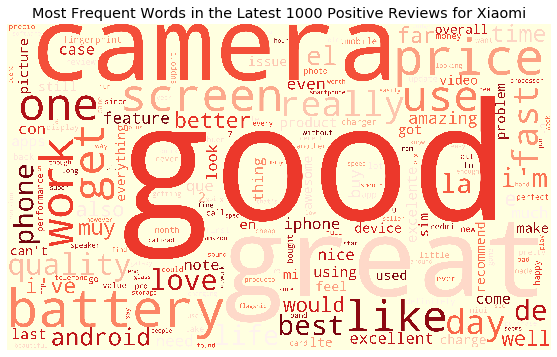

In [27]:
xiaomi_pos = " ".join(xiaomi[xiaomi["class"]==2]["clean_text"][0:1000])
xiaomi_pos_word_freq = word_freq_dict(xiaomi_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Reds",
                      background_color="lightyellow")
wordcloud_from_frequency(xiaomi_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Xiaomi")

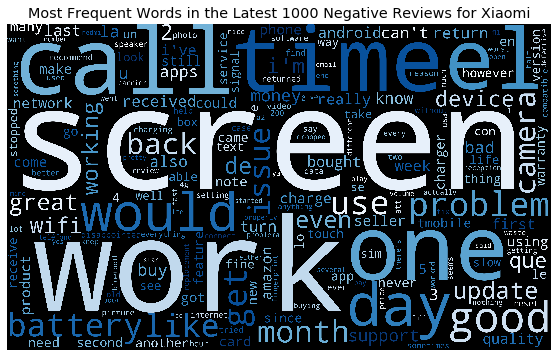

In [29]:
xiaomi_neg = " ".join(xiaomi[xiaomi["class"]==0]["clean_text"][0:1000])
xiaomi_neg_word_freq = word_freq_dict(xiaomi_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="black")
wordcloud_from_frequency(xiaomi_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Xiaomi")

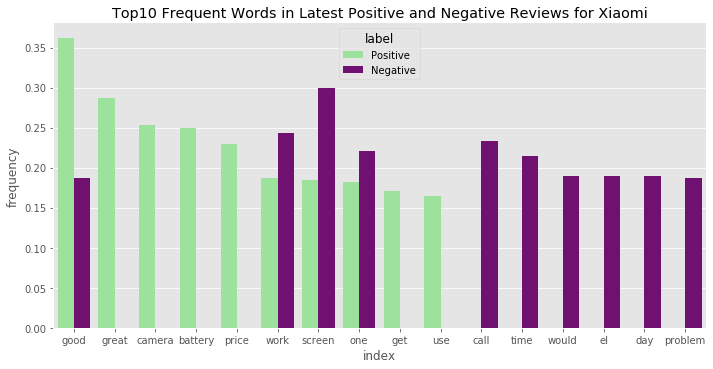

In [30]:
topn_wordfreq_bar_both(xiaomi_pos_word_freq, xiaomi_neg_word_freq, 
                       min(sum(xiaomi["class"]==2), 1000), 
                       min(sum(xiaomi["class"]==0), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Xiaomi", 
                       ["lightgreen", "purple"], 
                       height=5, aspect=2)

### **Install Langdetect and Only Keep English Reviews**

In [31]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 8.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=36853ef7a48fc4e0533b0c0e4abaca37676909ca33d1cfae64bd90b66f23a1b9
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [32]:
# Filtering English reviews
# Add language labels 
from langdetect import detect
def lang_detect(text):
    try:
        return detect(text)
    except:
        return None
import time
start_time = time.time()
reviews["lang"] = reviews["body"].apply(lang_detect)
print("It takes %s seconds for the code to finish." % (time.time() - start_time))

It takes 404.79868268966675 seconds for the code to finish.


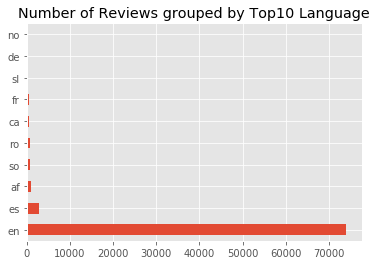

In [33]:
# Plot distribution of reviews into languages
reviews["lang"].value_counts()[:10].plot(kind="barh", title="Number of Reviews grouped by Top10 Language")
plt.show()

In [0]:
# Only take English reviews
reviews = reviews[reviews["lang"]=="en"]

### **Save Preprocessed Data to Google Mount Drive**

In [0]:
reviews.to_csv(path_or_buf='/content/drive/My Drive/Data Sets/reviews.csv')

## **Sentiment Analysis by Using Vader**

### **Download Vader and Load the packges**

In [35]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("It is a wonderful day.")

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'compound': 0.5719, 'neg': 0.0, 'neu': 0.448, 'pos': 0.552}

### **Create Sentiment Score**

In [37]:
start_time = time.time()
reviews["sent_neg"] = reviews["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["neg"])
reviews["sent_neu"] = reviews["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
reviews["sent_pos"] = reviews["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
reviews["sent_comp"] = reviews["clean_text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
print("It takes %s seconds for the code to finish." % (time.time() - start_time))

It takes 102.61701536178589 seconds for the code to finish.


In [0]:
reviews.to_csv(path_or_buf='/content/drive/My Drive/Data Sets/reviews_vader.csv')

### **Distribution of Vader Sentimemt Score**

In [0]:
path='/content/drive/My Drive/Data Sets/'
reviews_va = pd.read_csv(path+"reviews_vader.csv")

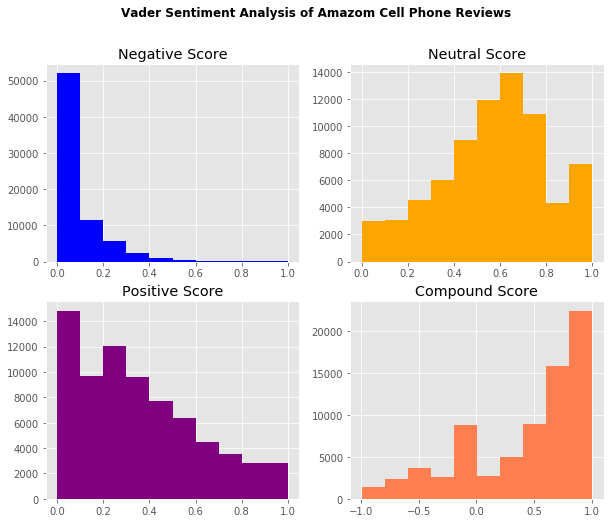

In [40]:
plt.figure()

plt.subplot(2, 2, 1)
reviews_va["sent_neg"].hist(figsize=(10, 8), color="blue")
plt.title("Negative Score")
plt.subplot(2, 2, 2)
reviews_va["sent_neu"].hist(figsize=(10, 8), color="orange")
plt.title("Neutral Score")
plt.subplot(2, 2, 3)
reviews_va["sent_pos"].hist(figsize=(10, 8), color="purple")
plt.title("Positive Score")
plt.subplot(2, 2, 4)
reviews_va["sent_comp"].hist(figsize=(10, 8), color="coral")
plt.title("Compound Score")

plt.suptitle('Vader Sentiment Analysis of Amazom Cell Phone Reviews', fontsize=12, fontweight='bold');

plt.show()

### **Correlation Between Sentiment Score and Rating**

The correlation coefficient between vader score (compound) and rating is  0.5794 with a p-value of  0.0000.


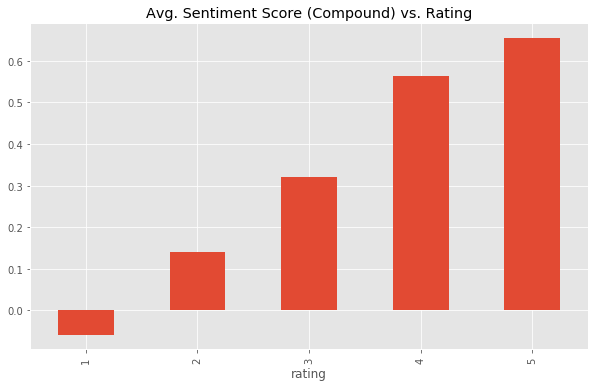

In [41]:
import numpy as np
import scipy.stats as stats
print("The correlation coefficient between vader score (compound) and rating is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(reviews_va["rating"], reviews_va["sent_comp"])))
reviews_va.groupby("rating").mean()["sent_comp"].plot(kind="bar", figsize=(10, 6))
plt.title("Avg. Sentiment Score (Compound) vs. Rating")
plt.show()

The correlation coefficient between vader score (compound) and class is  0.5724 with a p-value of  0.0000.


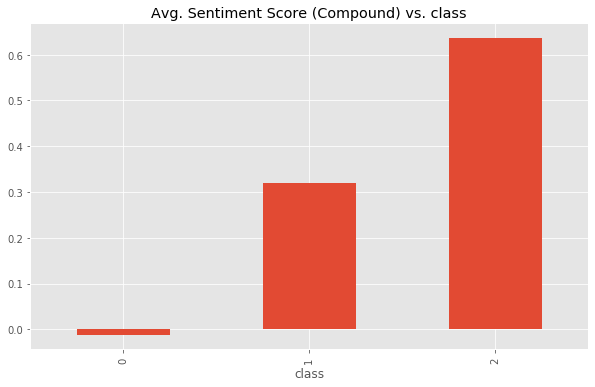

In [43]:
print("The correlation coefficient between vader score (compound) and class is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(reviews_va["class"], reviews_va["sent_comp"])))
reviews_va.groupby("class").mean()["sent_comp"].plot(kind="bar", figsize=(10, 6))
plt.title("Avg. Sentiment Score (Compound) vs. class")
plt.show()